In [1]:
import pandas as pd
from collections import defaultdict
import pickle
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline
# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


# Load the Page Ahead Book Up program information

In [2]:
with open('./data/interim/book_up_dict.pickle', 'rb') as handle:
    bookup_dct = pickle.load(handle)
type(bookup_dct)

collections.defaultdict

# Load the Map Assessment student information

In [3]:
map_df = pd.read_pickle("./data/interim/map_df.pkl")
print('shape=',map_df.shape)
map_df.columns

shape= (82049, 30)


Index(['StudentID', 'CurrentEnrollmentSchoolID', 'CurrentEnrollmentSchoolName',
       'CurrentGrade', 'TestSchoolYear', 'TestSeason', 'TestSchoolID',
       'TestSchoolName', 'TestGrade', 'SubjectArea', 'TestName', 'RITScore',
       'PercentileRank', 'MetGrowthLastFallToThisFall',
       'MetGrowthLastSpringToThisSpring', 'MetGrowthLastFallToThisSpring',
       'BirthDate', 'Gender', 'RacialEthnicGroup', 'ELLStatus', 'IEPStatus',
       'Student504Status', 'GiftedStatus', 'PrimaryLanguage', 'HomeLanguage',
       'LivingWith', 'USAEntryDate', 'BirthCountry', 'ProjectedGradYear',
       'ExtractSchoolYear'],
      dtype='object')

# Load the Smarter Balance Assessment Score Information

In [4]:
targets_df = pd.read_pickle("./data/interim/targets.pkl")
print('shape=',targets_df.shape)
targets_df.columns

shape= (4438, 30)


Index(['StudentID', 'CurrentEnrollmentSchoolID', 'CurrentEnrollmentSchoolName',
       'CurrentGrade', 'TestSchoolYear', 'TestSeason', 'TestSchoolID',
       'TestSchoolName', 'TestGrade', 'SubjectArea', 'TestName', 'AttemptCode',
       'Attempt', 'Score', 'LevelCode', 'MetStandard', 'BirthDate', 'Gender',
       'RacialEthnicGroup', 'ELLStatus', 'IEPStatus', 'Student504Status',
       'GiftedStatus', 'PrimaryLanguage', 'HomeLanguage', 'LivingWith',
       'USAEntryDate', 'BirthCountry', 'ProjectedGradYear',
       'ExtractSchoolYear'],
      dtype='object')

# A function that returns all the data for a given student

In [5]:
def get_student_data(studentID):
    """Gets all records for studentID from the map_df
    -----
    input: a string containing the studentID
    returns: a pandas dataframe of all columns of the map_df for studentID
    """
    df = map_df[map_df.StudentID==studentID]
    return df

A get_student_data usage example for a random studentID from targets_df:
* StudentID 3099442 was helpful for development of the get_treatments function.

In [6]:
example = get_student_data(targets_df.StudentID.sample().values[0])
example = get_student_data(3099442)
example

,StudentID,CurrentEnrollmentSchoolID,CurrentEnrollmentSchoolName,CurrentGrade,TestSchoolYear,TestSeason,TestSchoolID,TestSchoolName,TestGrade,SubjectArea,...,IEPStatus,Student504Status,GiftedStatus,PrimaryLanguage,HomeLanguage,LivingWith,USAEntryDate,BirthCountry,ProjectedGradYear,ExtractSchoolYear
36521,3099442,211,Frantz Coe Elementary,1,2015-16,Spring,211,Frantz Coe Elementary,1,Reading,...,N,N,Not Eligible,Spanish,Spanish,Both Parents,NaT,USA,(n/a),2015-16
91366,3099442,267,Roxhill Elementary,2,2016-17,Fall,211,Frantz Coe Elementary,2,Reading,...,N,N,Not Eligible,Spanish,Spanish,Both Parents,NaT,USA,(n/a),2016-17
91368,3099442,267,Roxhill Elementary,2,2016-17,Spring,267,Roxhill Elementary,2,Reading,...,N,N,Not Eligible,Spanish,Spanish,Both Parents,NaT,USA,(n/a),2016-17


An Example usage of the bookup_dct to find schools Page Ahead was serving for a given school year and grade:

In [7]:
bookup_dct[example.iloc[0].TestSchoolYear,example.iloc[0].TestGrade]

[215, 251, 219, 221, 220, 233, 275, 267]

Work to develop the get_treatments function:

In [8]:
summary = example.groupby(['TestSchoolYear','TestSchoolID','TestSeason']).RITScore.mean()

In [9]:
summary

TestSchoolYear  TestSchoolID  TestSeason
2015-16         211           Spring        176
2016-17         211           Fall          157
                267           Spring        184
Name: RITScore, dtype: int32

In [10]:
singleYear = example[example.TestSchoolYear=='2016-17']
gb=singleYear.groupby(['TestSchoolID','TestGrade','TestSeason']).RITScore.mean()
gb.index.levels

FrozenList([[211, 267], ['2'], ['Fall', 'Spring']])

In [11]:
gb

TestSchoolID  TestGrade  TestSeason
211           2          Fall          157
267           2          Spring        184
Name: RITScore, dtype: int32

In [12]:
summary.index.levels

FrozenList([['2015-16', '2016-17'], [211, 267], ['Fall', 'Spring']])

In [13]:
for i in range(0,len(gb)):
    print(gb.index[i],summary[i])

(211, '2', 'Fall') 176
(267, '2', 'Spring') 157


In [14]:
example.TestSchoolYear.unique()

array(['2015-16', '2016-17'], dtype=object)

Development cell for the get treatments function:

In [15]:
Treatments = []
for yr in example.TestSchoolYear.unique():
    yr_data = example[example.TestSchoolYear==yr]
    gb=yr_data.groupby(['TestSchoolID','TestGrade','TestSeason']).RITScore.mean()
    last = 0
    last_ind = 0
    for i in range(0,len(gb)):
        position = ['Fall','Winter','Spring'].index(gb.index[i][2])
        if position > last:
            last_ind = i
            last = position
    SchoolID = gb.index[last_ind][0]
    TestGrade = gb.index[last_ind][1]
    if SchoolID in bookup_dct[yr,TestGrade]:
        Treatments.append((int(yr[:4])+1,SchoolID))
#     print(yr,SchoolID,TestGrade)
#     print('len',len(gb))
#     print(yr,gb.index[i],summary[i])
#     print(yr,gb.index[i][2])
print(Treatments,len(Treatments))

[(2017, 267)] 1


# Functions used to build the independent variables

In [16]:
def get_RITs(stu_data,school_year):
    """Gets the mean any available MAP RIT scores for each test season
    (Fall, Winter, Spring) of the 2015-16 school year (1st Grade).
    -----
    Inputs: A dataframe containing all the students data from the map_df
            and the school year in the form of '2015-16'
    Returns: G1_Fall_RIT, G1_Winter_RIT, G1_Spring_RIT for the given year if available.
    """
    G1_Fall_RIT, G1_Winter_RIT, G1_Spring_RIT = None, None, None
    yr_data = stu_data[stu_data.TestSchoolYear==school_year]
    RIT_by_season = yr_data.groupby(['TestSeason']).RITScore.mean()
    for season in RIT_by_season.index:
        if season=='Fall':
            G1_Fall_RIT=RIT_by_season[season]
        if season=='Spring':
            G1_Spring_RIT=RIT_by_season[season]
        if season=='Winter':
            G1_Winter_RIT=RIT_by_season[season]
    return G1_Fall_RIT, G1_Winter_RIT, G1_Spring_RIT

In [17]:
get_RITs(example,'2015-16')

(None, None, 176)

In [18]:
def get_last_RIT(Fall_RIT,Winter_RIT,Spring_RIT):
    """Returns the RIT score from latest in the school year.
    ---
    input: RIT scores for Fall, Winter and Spring
    returns: the season name and the score of the score from latest in the school year.
    """
    if Spring_RIT is not None:
        return 'Spring',Spring_RIT
    elif Winter_RIT is not None:
        return 'Winter',Winter_RIT
    elif Fall_RIT is not None:
        return 'Fall', Fall_RIT
    return None, None

In [19]:
def get_treatments(stu_data):
    """Determines a list of the year and school students would have received 
    Book Up program treatments from Page Ahead.
    -----
    input: A dataframe containing all rows of map_df for a given student
    returns: A list of tuples of the year and school ID a student should have
             received Book Up program books in the summer.
    """
    treatments = []
    # For each year of the student's data...
    for yr in stu_data.TestSchoolYear.unique():
        yr_data = stu_data[stu_data.TestSchoolYear==yr]
        # Get a collection of the schools they tested at...
        gb=yr_data.groupby(['TestSchoolID','TestGrade','TestSeason']).RITScore.mean()
        # Determine which testing record was the last in the school year to estimate
        # which school they were attending...
        last = 0
        last_ind = 0
        for i in range(0,len(gb)):
            position = ['Fall','Winter','Spring'].index(gb.index[i][2])
            if position > last:
                last_ind = i
                last = position
        SchoolID = gb.index[last_ind][0]
        TestGrade = gb.index[last_ind][1]
        # If the school they were attending was being served by the Book Up program
        # of Page Ahead then record the year and school in the treatments list.
        if SchoolID in bookup_dct[yr,TestGrade]:
            treatments.append((int(yr[:4])+1,SchoolID))
    return treatments

Example usage of the get_treatments function with the example student data:

In [20]:
treat=get_treatments(example)
treat

[(2017, 267)]

# Building the X dataframe:

In [21]:
X_df = pd.DataFrame(columns=['StudentID','G1_Fall_RIT','G1_Winter_RIT','G1_Spring_RIT',\
                             'Last_G1_RIT','Last_G1_RIT_Season','Treatments','nTreatments'])
for studentID in targets_df.StudentID:
    Stu_data = get_student_data(studentID)
    G1_Fall_RIT, G1_Winter_RIT, G1_Spring_RIT = get_RITs(Stu_data,'2015-16')
    Last_RIT_Season, Last_RIT = get_last_RIT(G1_Fall_RIT, G1_Winter_RIT, G1_Spring_RIT)
    treatments = get_treatments(Stu_data)
    X_df = X_df.append({'StudentID':studentID,
                        'G1_Fall_RIT':G1_Fall_RIT,
                        'G1_Winter_RIT':G1_Winter_RIT,
                        'G1_Spring_RIT':G1_Spring_RIT,
                        'Last_G1_RIT':Last_RIT,
                        'Last_G1_RIT_Season':Last_RIT_Season,
                        'Treatments':treatments,
                        'nTreatments':int(len(treatments))
                       },ignore_index=True)

In [22]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438 entries, 0 to 4437
Data columns (total 8 columns):
StudentID             4438 non-null object
G1_Fall_RIT           1619 non-null object
G1_Winter_RIT         1254 non-null object
G1_Spring_RIT         3571 non-null object
Last_G1_RIT           3625 non-null object
Last_G1_RIT_Season    3625 non-null object
Treatments            4438 non-null object
nTreatments           4438 non-null object
dtypes: object(8)
memory usage: 277.5+ KB


Note that nTreatments is an ojbect.  I'll coerce it to an integer.

In [23]:
X_df.nTreatments = pd.to_numeric(X_df.nTreatments)

In [24]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438 entries, 0 to 4437
Data columns (total 8 columns):
StudentID             4438 non-null object
G1_Fall_RIT           1619 non-null object
G1_Winter_RIT         1254 non-null object
G1_Spring_RIT         3571 non-null object
Last_G1_RIT           3625 non-null object
Last_G1_RIT_Season    3625 non-null object
Treatments            4438 non-null object
nTreatments           4438 non-null int64
dtypes: int64(1), object(7)
memory usage: 277.5+ KB


In [25]:
X_df[X_df.nTreatments>0]

,StudentID,G1_Fall_RIT,G1_Winter_RIT,G1_Spring_RIT,Last_G1_RIT,Last_G1_RIT_Season,Treatments,nTreatments
19,3617411,165,169,178,178,Spring,"[(2016, 275), (2017, 275)]",2
31,3911457,None,168,181,181,Spring,"[(2016, 220), (2017, 220)]",2
35,3781456,None,None,135,135,Spring,"[(2016, 215), (2017, 215)]",2
36,3781489,None,None,None,None,None,"[(2017, 219)]",1
59,3163414,163,None,173,173,Spring,"[(2016, 215), (2017, 215)]",2
...,...,...,...,...,...,...,...,...
4400,3632746,None,None,176,176,Spring,"[(2016, 221)]",1
4402,3112415,None,164,169,169,Spring,"[(2016, 251), (2017, 251)]",2
4414,3173411,140,153,166,166,Spring,"[(2016, 275), (2017, 275)]",2
4419,3602411,None,177,166,166,Spring,"[(2016, 251), (2017, 251)]",2


In [26]:
print(len(X_df))
X_df.nTreatments.value_counts()

4438


0    3996
2     337
1     105
Name: nTreatments, dtype: int64

# Building the Targets Dataframe

In [27]:
Y_df = targets_df[targets_df.StudentID.isin(X_df.StudentID)][['StudentID',
                                                              'Score',
                                                              'LevelCode',
                                                              'MetStandard']]
print(len(Y_df))
Y_df.MetStandard.value_counts()

4438


Y    2879
N    1486
Name: MetStandard, dtype: int64

# Verify X and Y data are in the same StudentID order

In [28]:
Y_df[list(X_df.StudentID != Y_df.reset_index().StudentID)]

,StudentID,Score,LevelCode,MetStandard


In [29]:
Y_df

,StudentID,Score,LevelCode,MetStandard
32,3967736,2370.0,L2,N
35,3381735,2418.0,L2,N
57,3567417,2509.0,L4,Y
64,3130417,2525.0,L4,Y
66,3670417,2546.0,L4,Y
...,...,...,...,...
65279,3388733,2444.0,L3,Y
65380,3842783,2448.0,L3,Y
65420,3973780,2452.0,L3,Y
44699,3641452,2596.0,L4,Y


# MVP modeling

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

In [31]:
X = X_df[['StudentID','Last_G1_RIT','nTreatments']].copy()
Y = Y_df[['Score','LevelCode','MetStandard']].copy()

Remove all nan's.

In [32]:
X[X.isnull().any(axis=1)].count()

StudentID      813
Last_G1_RIT      0
nTreatments    813
dtype: int64

Need to delete the same rows in both X and Y.

In [33]:
df = pd.concat([X, Y.reset_index(drop=True)], axis=1)
df.set_index('StudentID',inplace=True)
df['Last_G1_RIT'].replace({None:np.nan},inplace=True)
df.dropna(inplace=True)
df[df.isnull().any(axis=1)]

,Last_G1_RIT,nTreatments,Score,LevelCode,MetStandard
StudentID,,,,,


In [34]:
df

,Last_G1_RIT,nTreatments,Score,LevelCode,MetStandard
StudentID,,,,,
3967736,178.0,0,2370.0,L2,N
3381735,173.0,0,2418.0,L2,N
3567417,196.0,0,2509.0,L4,Y
3130417,211.0,0,2525.0,L4,Y
3670417,192.0,0,2546.0,L4,Y
...,...,...,...,...,...
3388733,169.0,0,2444.0,L3,Y
3842783,169.0,0,2448.0,L3,Y
3973780,174.0,0,2452.0,L3,Y


In [35]:
X = df[['Last_G1_RIT','nTreatments']]
Y = df[['MetStandard']]

In [36]:
Y.MetStandard.value_counts()

Y    2442
N    1110
Name: MetStandard, dtype: int64

In [37]:
X.nTreatments.value_counts()

0    3169
2     329
1      54
Name: nTreatments, dtype: int64

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3552 entries, 3967736 to 3311443
Data columns (total 2 columns):
Last_G1_RIT    3552 non-null float64
nTreatments    3552 non-null int64
dtypes: float64(1), int64(1)
memory usage: 83.2 KB


In [39]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.33, random_state=42)

In [40]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr.MetStandard.ravel())
f1_score(lr.predict(X_te), y_te.MetStandard.ravel(),pos_label='Y')

0.8710462287104623

In [41]:
print(lr.coef_)
print(lr.intercept_)

[[ 0.12482869 -0.39727777]]
[-21.53487145]


In [42]:
print('Treatments=0',len(df[df.nTreatments==0]))
print('Treatments>0',len(df[df.nTreatments>0]))

Treatments=0 3169
Treatments>0 383


(2000, 2754.666694260485)

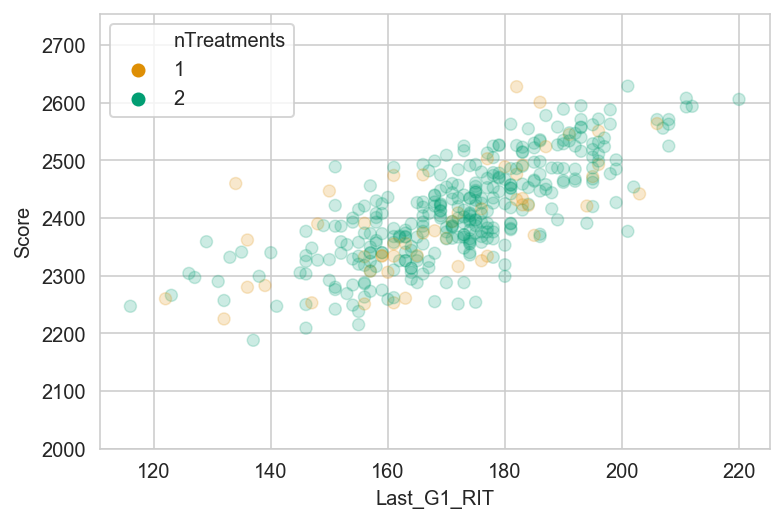

In [43]:
pal = dict(enumerate(sns.color_palette("colorblind", 3)))
sns.scatterplot('Last_G1_RIT', 'Score', data=df[df.nTreatments>0], hue='nTreatments',
           palette=pal, alpha=.2, edgecolor=None)
plt.ylim(bottom=2000)

(2000, 2818.7166942604854)

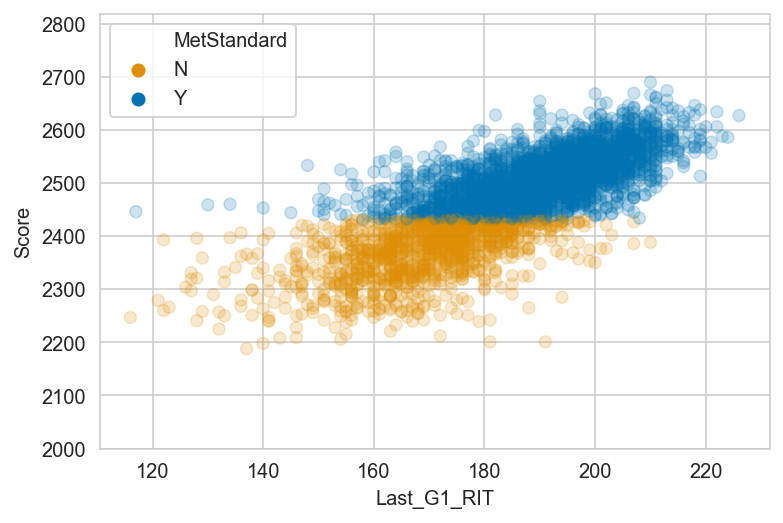

In [44]:
pal = dict(enumerate(sns.color_palette("colorblind", 2)))
pal2={'Y':pal[0],'N':pal[1]}
sns.scatterplot('Last_G1_RIT', 'Score', data=df, hue='MetStandard',
           palette=pal2, alpha=.2, edgecolor=None)
plt.ylim(bottom=2000)

In [45]:
X = df[['nTreatments']]
Y = df[['MetStandard']]
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.33, random_state=42)
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr.MetStandard.ravel())
f1_score(lr.predict(X_te), y_te.MetStandard.ravel(),pos_label='Y')

0.8085561497326204

In [46]:
print(lr.coef_)
print(lr.intercept_)

[[-0.72849735]]
[0.98266921]


In [47]:
X = df[['Last_G1_RIT']]
Y = df[['MetStandard']]
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.33, random_state=42)
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr.MetStandard.ravel())
f1_score(lr.predict(X_te), y_te.MetStandard.ravel(),pos_label='Y')

0.875

In [48]:
print(lr.coef_)
print(lr.intercept_)

[[0.12749652]]
[-22.1087737]


In [49]:
Y_df.MetStandard.value_counts()

Y    2879
N    1486
Name: MetStandard, dtype: int64

In [50]:
df

,Last_G1_RIT,nTreatments,Score,LevelCode,MetStandard
StudentID,,,,,
3967736,178.0,0,2370.0,L2,N
3381735,173.0,0,2418.0,L2,N
3567417,196.0,0,2509.0,L4,Y
3130417,211.0,0,2525.0,L4,Y
3670417,192.0,0,2546.0,L4,Y
...,...,...,...,...,...
3388733,169.0,0,2444.0,L3,Y
3842783,169.0,0,2448.0,L3,Y
3973780,174.0,0,2452.0,L3,Y


In [69]:
targets_df[targets_df.Score<500].iloc[:,:16]

,StudentID,CurrentEnrollmentSchoolID,CurrentEnrollmentSchoolName,CurrentGrade,TestSchoolYear,TestSeason,TestSchoolID,TestSchoolName,TestGrade,SubjectArea,TestName,AttemptCode,Attempt,Score,LevelCode,MetStandard
474,3019447,245,Lowell Elementary,4,2017-18,Spring,245,Lowell Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,116.0,L2,N
4756,6848596,229,Green Lake Elementary,4,2017-18,Spring,277,View Ridge Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,135.0,L3,Y
5851,3968480,930,Pathfinder K-8 School,4,2017-18,Spring,930,Pathfinder K-8 School,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,176.0,L4,Y
7105,3881712,930,Pathfinder K-8 School,4,2017-18,Spring,930,Pathfinder K-8 School,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,180.0,L4,Y
10288,3148447,212,Thurgood Marshall Elementary,4,2017-18,Spring,212,Thurgood Marshall Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,173.0,L4,Y
12835,3462714,236,West Seattle Elementary,4,2017-18,Spring,267,Roxhill Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,135.0,L3,Y
13827,3565756,212,Thurgood Marshall Elementary,4,2017-18,Spring,212,Thurgood Marshall Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,115.0,L2,N
20011,3518483,220,Graham Hill Elementary,4,2017-18,Spring,220,Graham Hill Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,138.0,L3,Y
21412,6618723,273,Sanislo Elementary,4,2017-18,Spring,273,Sanislo Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,123.0,L2,N
21891,3173748,268,Sacajawea Elementary,4,2017-18,Spring,268,Sacajawea Elementary,3,Reading/ELA,Access to Instruction & Measurement,TS,Tested,101.0,L1,N


In [112]:
df2=df.replace({'Y':1,'N':0})
df2

,Last_G1_RIT,nTreatments,Score,LevelCode,MetStandard
StudentID,,,,,
3967736,178.0,0,2370.0,L2,0
3381735,173.0,0,2418.0,L2,0
3567417,196.0,0,2509.0,L4,1
3130417,211.0,0,2525.0,L4,1
3670417,192.0,0,2546.0,L4,1
...,...,...,...,...,...
3388733,169.0,0,2444.0,L3,1
3842783,169.0,0,2448.0,L3,1
3973780,174.0,0,2452.0,L3,1


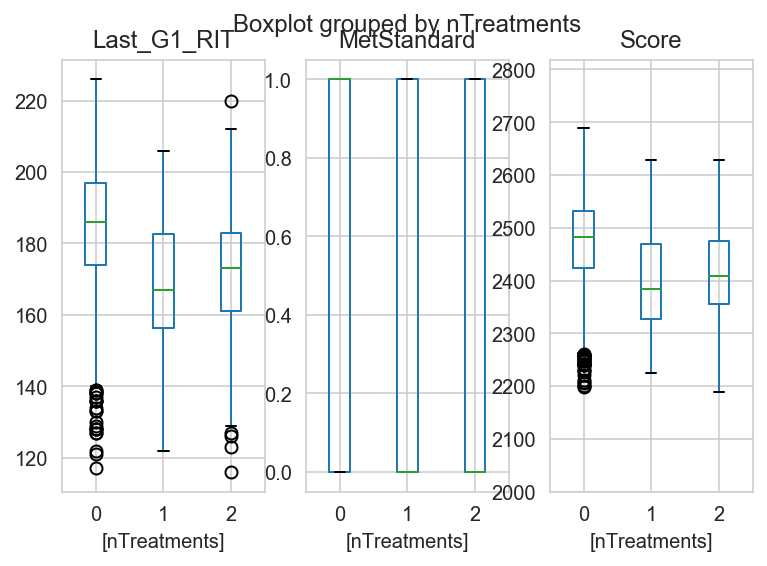

In [114]:
fig, ax_new = plt.subplots(1,3,sharey=False)
bp = df2.boxplot(by='nTreatments',ax=ax_new)
plt.ylim(bottom=2000);

In [52]:
Met0=pd.DataFrame(df[df.nTreatments==0].MetStandard.replace({'Y':1,'N':0}))
Met1=pd.DataFrame(df[df.nTreatments==1].MetStandard.replace({'Y':1,'N':0}))
Met2=pd.DataFrame(df[df.nTreatments==2].MetStandard.replace({'Y':1,'N':0}))
Met=pd.concat([Met0.reset_index(drop=True),Met1.reset_index(drop=True),Met2.reset_index(drop=True)],axis=1,ignore_index=True)
Met

,0,1,2
0,0,1.0,1.0
1,0,1.0,0.0
2,1,0.0,0.0
3,1,1.0,1.0
4,1,0.0,0.0
...,...,...,...
3164,1,NaN,NaN
3165,1,NaN,NaN
3166,1,NaN,NaN
3167,1,NaN,NaN


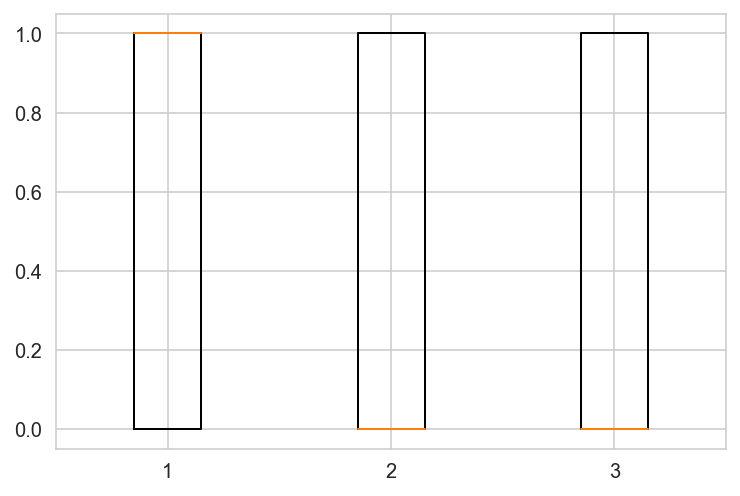

In [54]:
fig, ax = plt.subplots()
ax.boxplot([Met0.MetStandard,Met1.MetStandard,Met2.MetStandard]);

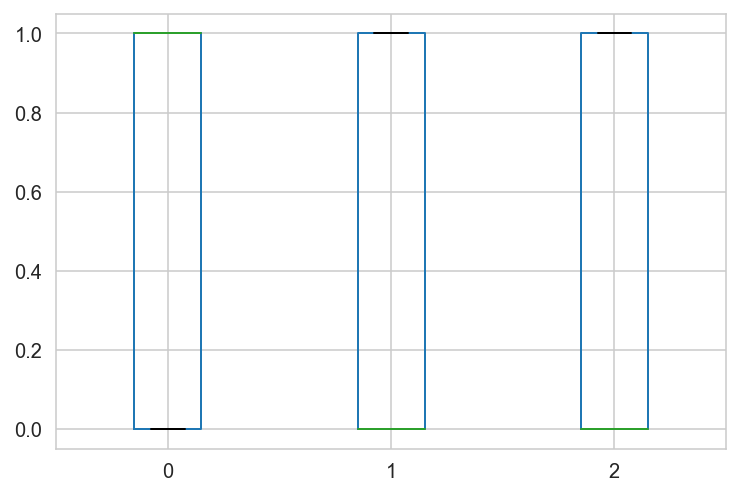

In [55]:
boxplot = Met.boxplot()

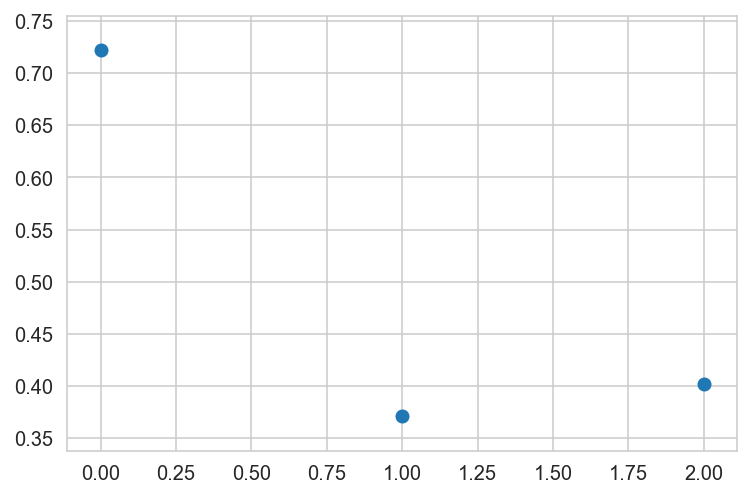

In [56]:
fig, ax = plt.subplots()
ax.scatter([0,1,2],[Met0.mean(),Met1.mean(),Met2.mean()]);

In [53]:
Met[2].value_counts()

0.0    197
1.0    132
Name: 2, dtype: int64

In [106]:
132/(132+197)

0.4012158054711246